# Explore NASA's Cloud-Optimized GeoTIFFs

This notebook includes a few examples for how to open and explore Cloud-Optimized GeoTIFFs using tools such as [mercantile](https://github.com/mapbox/mercantile), [titiler](https://github.com/developmentseed/titiler/tree/master/titiler) and [mapboxgl](https://github.com/mapbox/mapboxgl-jupyter).

Run as-is or change date, variable and city parameters. Cities available at this time are:

* `los_angeles`
* `new_york`
* `san_fran`
* `beijing`
* `tokyo`

Variables availble are:

* `no2`: Nitrogen Dioxide
* `aod`: Aerosol Optical Depth
* `vi`: Normalized difference vegetation index (NDVI)

In [1]:
# Load necessary libraries
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Configure AWS keys

**You will need to set these to something valid!**

In [2]:
os.environ["AWS_ACCESS_KEY_ID"] = 'XXX'
os.environ["AWS_SECRET_ACCESS_KEY"] = 'XXX'
os.environ["CURL_CA_BUNDLE"] = '/etc/ssl/certs/ca-certificates.crt'
from helpers import *

## Plot a histogram of NDVI for each city on a given day

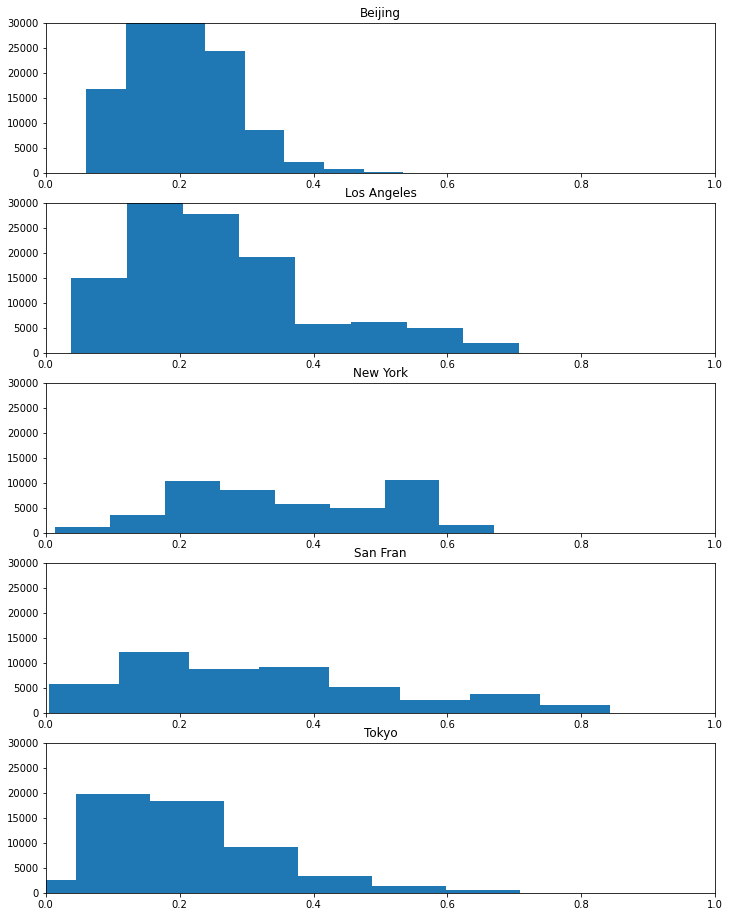

In [3]:
date = datetime(2020, 4, 1)
plt.rcParams["figure.figsize"] = (12, 16)
fig, axs = plt.subplots(5)
variable = 'vi'
zoom = 10

for idx, city in enumerate(latlons.keys()):
    tile = get_city_tile(dict(collection=variable, date=date, zoom=zoom, city=city))    
    data = tile[tile != nodata_values[variable]]
    axis = axs[idx]
    axis.hist(data, bins=8)
    axis.set_title(city_title(city))
    axis.set_ylim(0, 30000)
    axis.set_xlim(0, 1)

## Plot a timeseries of AOD values

...and compare year over year, 2018-2020.
Note: this will take a few minutes to run.

In [4]:
%%time

years = [2020, 2019, 2018]
variable = 'aod'
city = 'los_angeles'
zoom = 8
values = {}
for year in years:
    dates = pd.date_range(datetime(year, 1, 1), datetime(year, 5, 26), freq='5d')
    values[year] = {'dates': [], 'values': []}
    for date in dates:
        tile = get_city_tile(dict(collection=variable, date=date, zoom=zoom, city=city))
        values[year]['dates'].append(date)
        values[year]['values'].append(np.median(tile[tile != nodata_values[variable]]))

CPU times: user 7.48 s, sys: 3.43 s, total: 10.9 s
Wall time: 2min 8s


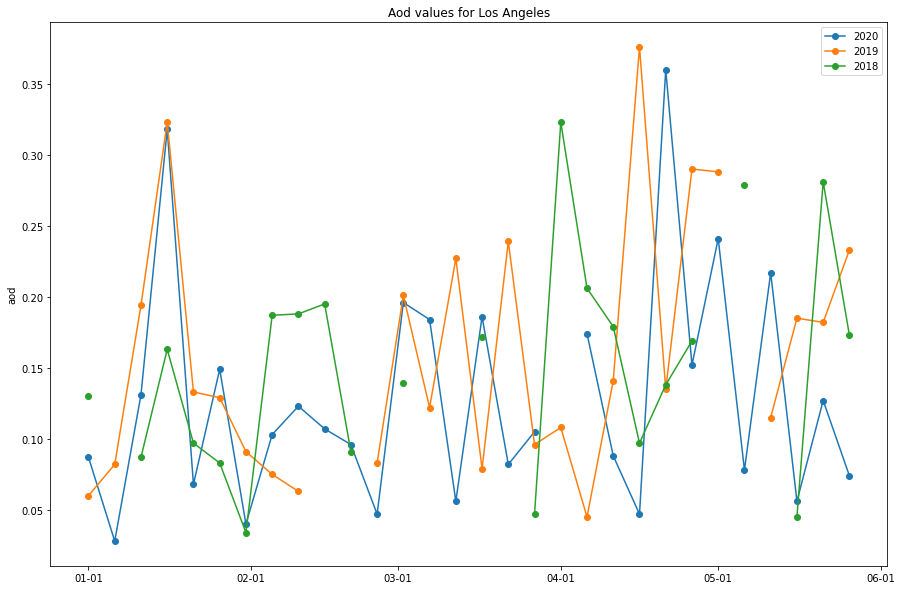

In [5]:
%matplotlib inline

month_fmt = mdates.DateFormatter('%m-%d')
plt.rcParams["figure.figsize"] = (15, 10)
fig, ax = plt.subplots()
x = values[2018]['dates']

for idx, year in enumerate(years):
    y = values[year]['values']
    ax.plot(x, y, 'o-', label=str(year))

# format the ticks
ax.xaxis.set_major_formatter(month_fmt)

plt.title(f'{variable.title()} values for {city_title(city)}')
plt.ylabel(variable)
plt.legend()
plt.show()

## Visualize AOD data

In [8]:
from ipyleaflet import Map, basemaps, TileLayer, basemap_to_tiles

city = 'san_fran'
tiles_center = [latlons[city]['lat'], latlons[city]['lon']]
center = tiles_center
zoom = 6
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

tile_url = get_tile_url(dict(collection='aod', date=datetime(2020, 4, 24), zoom=zoom, city=city))
tiles_url = "https://pfg2k5mjei.execute-api.us-west-2.amazonaws.com/v1/{z}/{x}/{y}@1x?" + \
  f"url={tile_url}&bidx=1&rescale=0.03,0.5&color_map=magma"

aod_layer = TileLayer(
    url=tiles_url,
    opacity=0.6
)
m.add_layer(aod_layer)
m

Map(center=[37.7775, -122.416389], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…